# 1. Introdução

Neste notebook, construímos um modelo de análise de sentimentos para resenhas de livros em português.
O objetivo é classificar cada resenha como **positiva** ou **negativa**, passando por:

- análise exploratória do texto,
- pré-processamento,
- vetorização com TF-IDF,
- treinamento de um modelo supervisionado,
- avaliação do desempenho,
- e teste manual com frases novas.

A abordagem é simples, eficiente e reprodutível.


# 2. Carregamento dos Dados

Nesta seção, realizamos a leitura dos arquivos contendo resenhas positivas e negativas
e organizamos tudo em um único `DataFrame` para facilitar as análises posteriores.


In [1]:
%pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [2]:

# -*- coding: utf-8 -*-
# Projeto: Análise de Sentimentos em Comentários de Livros
# Arquivo: analise_exploratoria.ipynb
# Descrição: Notebook para leitura do dataset da Amazon, análise exploratória e visualização básica.
#
# Integrantes:
# - Maria Gabriela Barros – RA: 10409037 – 10409037@mackenzista.com.br
# - Raphaela Polonis – RA: 10408843 – 10408843@mackenzista.com.br
# - Felipe Carvalho – RA: 1049804 – 104098043@mackenzista.com.br
# - Bruno Gustavo Rocha – RA: 10400926 – 10400926@mackenzista.com.br
#
# Histórico de alterações:
# - 20/09/2025 – Maria Gabriela Barros – Criação do notebook inicial com leitura do dataset e checagem do balanceamento.
# - 22/09/2025 – Raphaela Polonis – Implementação da etapa de pré-processamento (remoção de stopwords, limpeza de texto e normalização).
# - 23/09/2025 – Felipe Carvalho – Desenvolvimento da análise exploratória: histogramas, distribuição de classes e geração das nuvens de palavras.
# - 23/09/2025 – Bruno Gustavo Rocha – Implementação do modelo baseline (TF-IDF + Regressão Logística) e avaliação (acurácia, classification report, testes manuais).
# - 27/09/2025 – Raphaela Polonis – Organização do repositório GitHub (criação de pastas /dataset, /src, /notebooks e atualização do README).
# - 28/09/2025 – Maria Gabriela Barros – Revisão final do código, inclusão de exemplos de predições em frases novas e ajustes para entrega.
# - 28/09/2025 – Felipe Carvalho & Bruno Gustavo Rocha – Testes adicionais e validação final
# - 22/11/2025 - Bruno Gustavo Rocha - Correção de Bugs
# - 22/11/2025 - Felipe Carvalho - Correção de comentários
# - 22/11/2025 - Raphaela Polonis - Implementação da matriz de confusão
# - 23/11/2025 - Bruno e Maria - Correção de comentários (documentação do código)

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [3]:
# Leitura dos arquivos de resenhas positivas e negativas.
# Cada linha dos arquivos representa uma resenha completa.
# Usamos encoding="utf-8" para garantir que acentos e caracteres especiais em português
# sejam lidos corretamente, evitando problemas de codificação.
with open("books_pt_pos.txt", "r", encoding="utf-8") as f:
    pos = f.readlines()

with open("books_pt_neg.txt", "r", encoding="utf-8") as f:
    neg = f.readlines()


# Criação de dois DataFrames separados:
# - df_pos: contém apenas resenhas positivas
# - df_neg: contém apenas resenhas negativas
# A coluna "review" guarda o texto da resenha
# A coluna "sentiment" guarda o rótulo de classe (positivo/negativo),
# que será usado como variável alvo no modelo de classificação.
df_pos = pd.DataFrame({"review": pos, "sentiment": "positivo"})
df_neg = pd.DataFrame({"review": neg, "sentiment": "negativo"})

# Unimos os dois DataFrames em um único conjunto de dados (df),
# empilhando as linhas de df_pos e df_neg.
# O reset_index(drop=True) garante que o índice seja renumerado de 0 até n-1,
# o que facilita análises posteriores e evita índices duplicados.
df = pd.concat([df_pos, df_neg]).reset_index(drop=True)

# Exibimos as primeiras linhas para inspecionar rapidamente
# se a estrutura (colunas e alguns exemplos) está como esperado.
df.head()

,review,sentiment
0,Enfim o final da série chegou e me deixou arre...,positivo
1,Aiai! Agora ficamos órfãos dos Lafaiete 😔 A hi...,positivo
2,"Lara smithe fechou a série com chave de ouro,q...",positivo
3,Mais uma vez a Lara Smithe nos deixa de boca a...,positivo
4,Ótima ideia: aglutinar os livros dos quatro ir...,positivo


# 3. Análise Exploratória (EDA)

Antes de treinar qualquer modelo, é importante entender a estrutura do conjunto de dados:
distribuição de classes, tamanho das resenhas e vocabulário predominante.


## 3.1 Distribuição das Classes

Aqui verificamos se há equilíbrio entre o número de resenhas positivas e negativas,
o que impacta diretamente o treinamento do modelo.


sentiment
positivo    1000
negativo    1000
Name: count, dtype: int64


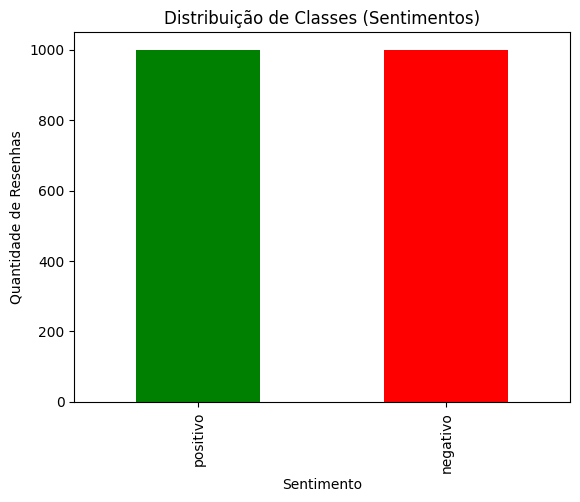

In [4]:
# Contagem das classes (positivo e negativo).
# Isso permite verificar rapidamente se o dataset está balanceado.
# Um conjunto equilibrado entre as classes é importante para evitar
# que o modelo aprenda a "favorecer" uma das categorias.
print(df['sentiment'].value_counts())


# Visualização da distribuição das classes em um gráfico de barras.
# O objetivo é observar de forma clara se há desbalanceamento significativo.
# Cada barra representa a quantidade de resenhas positivas e negativas.
df['sentiment'].value_counts().plot(
    kind='bar',
    color=['green', 'red'],  # Cores reforçando o tipo de sentimento
)

plt.title("Distribuição de Classes (Sentimentos)")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade de Resenhas")
plt.show()

## 3.2 Tamanho dos Textos

Analisamos o comprimento das resenhas, tanto em caracteres quanto em número de palavras,
para entender se o corpus é formado por textos mais curtos, longos ou intermediários.


In [5]:
# Criamos uma coluna chamada "length" contendo o número de caracteres de cada resenha.
# Isso ajuda a identificar padrões de tamanho textual — por exemplo,
# se textos positivos tendem a ser mais curtos ou mais longos que os negativos.
# Essa informação pode ser útil na análise exploratória.
df['length'] = df['review'].apply(len)

# Exibimos as estatísticas descritivas do tamanho em caracteres:
# (mínimo, máximo, média, quartis, etc.)
print(df['length'].describe())

print("\n")

# Também calculamos o número de palavras de cada resenha.
# O critério de contagem em palavras é frequentemente mais interpretável
# do que apenas contar caracteres, pois fornece uma noção real do "tamanho" semanticamente útil.
df["word_count"] = df["review"].apply(lambda t: len(t.split()))

# Exibimos as estatísticas do número de palavras nas resenhas.
# Isso complementa a análise acima e nos ajuda a entender a estrutura média dos textos.
print(df["word_count"].describe())

count    2000.000000
mean      362.187000
std       407.991167
min         1.000000
25%       152.000000
50%       244.000000
75%       411.000000
max      6805.000000
Name: length, dtype: float64


count    2000.00000
mean       61.05400
std        69.14648
min         0.00000
25%        25.00000
50%        41.00000
75%        70.00000
max      1143.00000
Name: word_count, dtype: float64


## 3.3 Nuvem de Palavras (Texto Bruto)

Visualizamos as palavras mais frequentes nas resenhas positivas e negativas **antes** do pré-processamento,
para termos uma primeira impressão do vocabulário utilizado em cada classe.


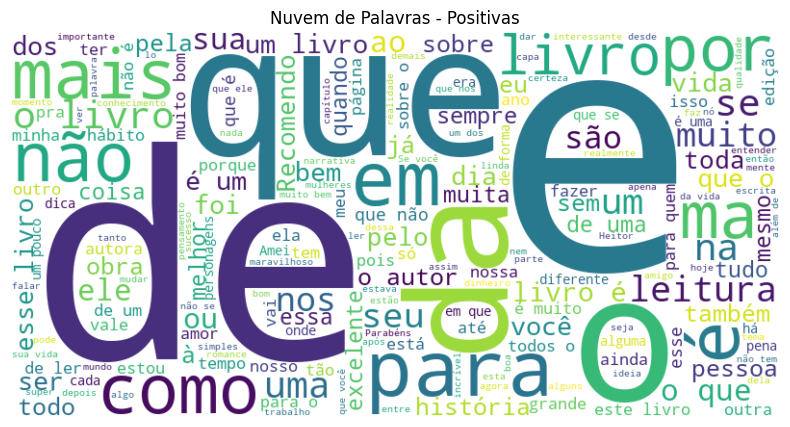

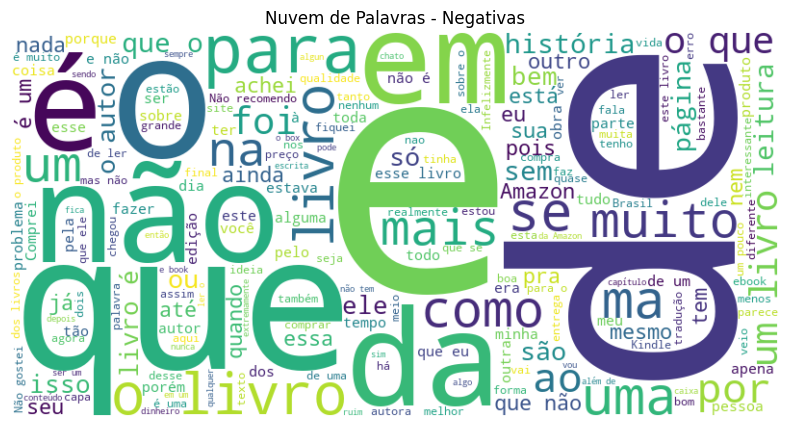

In [6]:
# Função responsável por gerar uma nuvem de palavras (WordCloud) a partir de um conjunto de textos.
# A ideia é visualizar graficamente quais termos aparecem com maior frequência,
# já que as palavras mais frequentes aparecem maiores e mais destacadas.
# Essa visualização é útil tanto para análise exploratória quanto para confirmar
# diferenças de vocabulário entre resenhas positivas e negativas.
def plot_wordcloud(texts, title):
    # Gera a nuvem combinando todos os textos em uma única string
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"  # fundo branco para melhorar a legibilidade
    ).generate(" ".join(texts))

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")  # Renderização suave da imagem
    plt.axis("off")  # Remove eixos para dar destaque somente à nuvem
    plt.title(title)
    plt.show()


# Nuvem de palavras para resenhas positivas.
# Ajuda a identificar termos que caracterizam avaliações com sentimento positivo.
plot_wordcloud(df[df['sentiment'] == "positivo"]['review'], "Nuvem de Palavras - Positivas")

# Nuvem de palavras para resenhas negativas.
# Permite observar a frequência de palavras ligadas a insatisfação ou críticas.
plot_wordcloud(df[df['sentiment'] == "negativo"]['review'], "Nuvem de Palavras - Negativas")

# 4. Pré-processamento de Texto

Nesta etapa, aplicamos um pipeline de limpeza para normalizar as resenhas:

- remoção de acentos,
- conversão para minúsculas,
- remoção de pontuação,
- remoção de *stopwords*.

O objetivo é reduzir ruídos e preparar os textos para a vetorização com TF-IDF.


In [7]:
# Instalação das bibliotecas necessárias para o pré-processamento de texto.
# - nltk: fornece recursos de PLN, como stopwords, tokenização e ferramentas linguísticas.
# - unidecode: remove acentos e normaliza caracteres, o que facilita o processamento posterior.
# A instalação via pip só é executada caso o ambiente ainda não tenha essas dependências.
%pip install nltk unidecode

import nltk

# Download da lista de stopwords para o idioma português.
# Stopwords são palavras muito comuns (ex.: "de", "a", "para") que normalmente
# não carregam significado relevante para análise de sentimento.
# Ter esse recurso disponível é essencial para a etapa de limpeza dos textos.
nltk.download("stopwords")

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to C:\Users\Bruno
[nltk_data]     Rocha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
import string

# Carrega a lista de stopwords em português fornecida pelo NLTK.
# Stopwords são palavras extremamente frequentes na língua (ex.: "de", "a", "para")
# que geralmente não contribuem para distinguir sentimentos positivos ou negativos.
# Removê-las ajuda o modelo a focar apenas no vocabulário relevante.
stopwords_pt = set(stopwords.words("portuguese"))


def limpar_texto(texto):
    """
    Função de pré-processamento responsável por normalizar cada resenha.
    Esta etapa é fundamental para reduzir ruído textual e padronizar o formato
    antes da vetorização TF-IDF e do treinamento do modelo.
    """

    # Remove acentos e normaliza caracteres especiais, facilitando a análise.
    texto = unidecode(texto)

    # Converte tudo para minúsculas, garantindo consistência entre palavras iguais.
    texto = texto.lower()

    # Remove pontuação (vírgulas, pontos, exclamações, etc.).
    # A presença de pontuação normalmente não influencia o sentimento na análise clássica.
    texto = texto.translate(str.maketrans("", "", string.punctuation))

    # Remove as stopwords, mantendo apenas palavras relevantes para o modelo.
    palavras = [p for p in texto.split() if p not in stopwords_pt]

    # Reconstrói o texto sem ruídos.
    return " ".join(palavras)


# Aplica o pré-processamento em todas as resenhas originais.
# Isso gera uma nova coluna ("clean_review") que será usada
# nas próximas etapas de vetorização e modelagem.
df['clean_review'] = df['review'].apply(limpar_texto)

# Exibimos lado a lado a versão original e a limpa
# para conferir se o pré-processamento ocorreu conforme esperado.
df[['review', 'clean_review']].head()


,review,clean_review
0,Enfim o final da série chegou e me deixou arre...,enfim final serie chegou deixou arrebatada emo...
1,Aiai! Agora ficamos órfãos dos Lafaiete 😔 A hi...,aiai agora ficamos orfaos lafaiete historia am...
2,"Lara smithe fechou a série com chave de ouro,q...",lara smithe fechou serie chave ouroque amor li...
3,Mais uma vez a Lara Smithe nos deixa de boca a...,vez lara smithe deixa boca aberta saber dizer ...
4,Ótima ideia: aglutinar os livros dos quatro ir...,otima ideia aglutinar livros quatro irmaos laf...


## 4.1 Nuvem de Palavras (Texto Limpo)

Após o pré-processamento, geramos novamente nuvens de palavras para cada classe,
agora destacando apenas termos relevantes, sem acentos, pontuação ou stopwords.


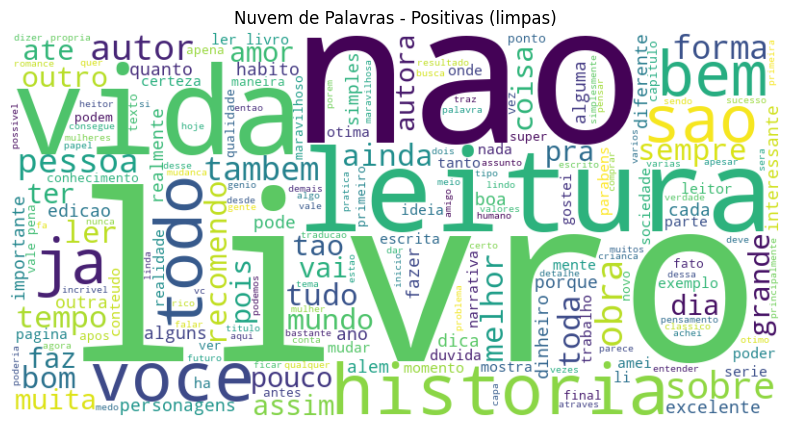

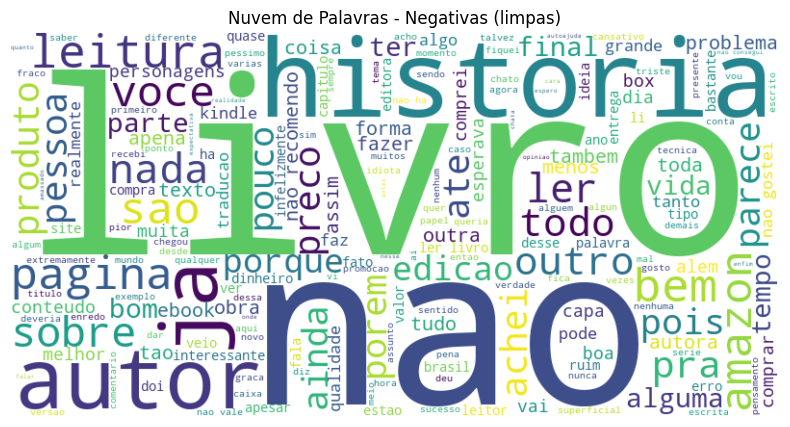

In [9]:
# Função responsável por gerar uma nuvem de palavras (WordCloud).
# Aqui usamos os textos já pré-processados ("clean_review"),
# o que garante que a nuvem destaque apenas termos realmente relevantes —
# sem acentos, sem stopwords e sem pontuação.
# Isso facilita a visualização de padrões de vocabulário entre as classes.
def plot_wordcloud(texts, title):
    # Gera a nuvem de palavras combinando todos os textos em uma única string
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"  # Fundo branco para melhor contraste
    ).generate(" ".join(texts))

    # Plotagem da nuvem
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")  # Renderização suave
    plt.axis("off")  # Remove eixos para focar apenas no conteúdo visual
    plt.title(title)
    plt.show()


# Nuvem de palavras para resenhas positivas após pré-processamento.
# Agora é possível observar termos que realmente caracterizam sentimento positivo,
# já que ruídos linguísticos foram removidos.
plot_wordcloud(
    df[df['sentiment'] == "positivo"]['clean_review'],
    "Nuvem de Palavras - Positivas (limpas)"
)

# Nuvem de palavras para resenhas negativas, também já normalizadas.
# O objetivo é identificar padrões linguísticos associados a críticas,
# insatisfação ou avaliações negativas em geral.
plot_wordcloud(
    df[df['sentiment'] == "negativo"]['clean_review'],
    "Nuvem de Palavras - Negativas (limpas)"
)

# 5. Vetorização e Treinamento do Modelo

Com os textos limpos, transformamos as resenhas em vetores numéricos usando **TF-IDF**
(considerando unigramas e bigramas) e treinamos um modelo de **Regressão Logística**
para classificar as resenhas como positivas ou negativas.


# 6. Avaliação do Modelo

Avaliamos o desempenho do modelo usando acurácia, precisão, recall, F1-score
e matriz de confusão, analisando os acertos e erros em cada classe.


Acurácia: 0.875
              precision    recall  f1-score   support

    negativo       0.86      0.89      0.88       200
    positivo       0.89      0.86      0.87       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.87       400
weighted avg       0.88      0.88      0.87       400



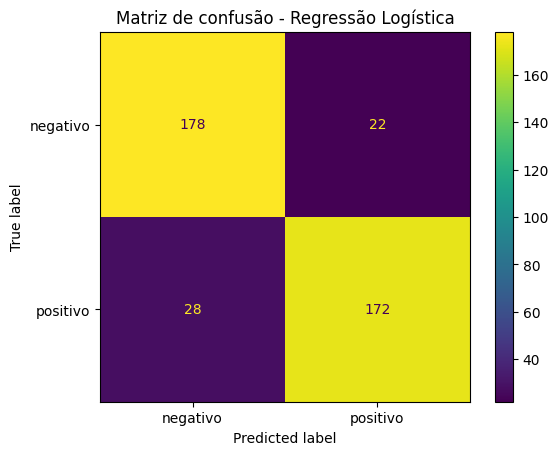

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Selecionamos a variável explicativa (X) e a variável alvo (y).
# X: textos já pré-processados (clean_review), prontos para serem vetorizados.
# y: rótulos de sentimento mapeados para números (0 = negativo, 1 = positivo),
#    formato mais adequado para os algoritmos de classificação.
X = df['clean_review']
y = df['sentiment'].map({"negativo": 0, "positivo": 1})


# Dividimos o conjunto de dados em treino e teste.
# - test_size=0.2: 20% dos dados ficam para teste, 80% para treino.
# - random_state=42: fixa a semente aleatória, garantindo reprodutibilidade dos resultados.
# - stratify=y: mantém a proporção de classes (positivo/negativo) semelhante em treino e teste,
#   evitando desbalanceamento acidental.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# Vetorização com TF-IDF.
# Transformamos o texto em vetores numéricos, onde cada dimensão representa um termo
# e o valor indica sua importância (frequência no documento ponderada pela raridade no corpus).
# - ngram_range=(1,2): considera unigramas e bigramas (palavras isoladas e pares de palavras),
#   capturando um pouco de contexto local.
# - min_df=2: ignora termos que aparecem em apenas um documento, reduzindo ruído e dimensionalidade.
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_train_vec = tfidf.fit_transform(X_train)  # Ajusta o vocabulário e transforma o treino
X_test_vec = tfidf.transform(X_test)        # Usa o mesmo vocabulário para transformar o teste


# Definimos o modelo de Regressão Logística.
# Esse algoritmo é amplamente utilizado para classificação binária,
# eficiente e interpretável para tarefas de análise de sentimento.
clf = LogisticRegression(max_iter=2000)

# Treinamos o modelo usando as resenhas vetorizadas e os rótulos de treino.
clf.fit(X_train_vec, y_train)


# Geramos as previsões para o conjunto de teste.
y_pred = clf.predict(X_test_vec)

# Acurácia geral do modelo: porcentagem de previsões corretas.
print("Acurácia:", accuracy_score(y_test, y_pred))

# Relatório de classificação contendo:
# - precisão (precision)
# - revocação (recall)
# - F1-score (equilíbrio entre precisão e revocação)
# para cada classe (negativo e positivo), além de métricas agregadas.
print(classification_report(y_test, y_pred, target_names=["negativo", "positivo"]))


# Matriz de confusão:
# Linha = classe verdadeira, Coluna = classe prevista.
# Ela mostra quantos exemplos foram corretamente classificados e
# quantos foram confundidos entre positivo e negativo.
cm = confusion_matrix(y_test, y_pred)

# Exibição gráfica da matriz de confusão,
# facilitando a interpretação visual dos acertos e erros do modelo.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negativo", "positivo"])
disp.plot()
plt.title("Matriz de confusão - Regressão Logística")
plt.show()

# 7. Testes Manuais com Frases Novas

Por fim, testamos o modelo com algumas frases de exemplo para verificar,
de forma qualitativa, se as previsões fazem sentido no mundo real.


In [11]:
# Lista de exemplos para testar manualmente o modelo treinado.
# Aqui usamos frases que simulam resenhas reais, incluindo:
# - um exemplo claramente positivo,
# - um claramente negativo,
# - e um intermediário/ambíguo.
# Esse tipo de teste é importante para validar qualitativamente
# o comportamento do classificador fora do conjunto de treino.
exemplos = [
    "Amei a história, personagens cativantes e final emocionante!",
    "Péssimo, confuso e cansativo. Não recomendo.",
    "Achei ok, mas esperava mais do enredo."
]

# Aplicamos o mesmo pré-processamento usado no dataset original.
# Isso garante coerência: o modelo só pode analisar corretamente
# frases que tenham passado pelo mesmo pipeline de limpeza.
ex_limpos = [limpar_texto(t) for t in exemplos]

# Transformamos os textos limpos em vetores TF-IDF using o mesmo
# vetorizar já treinado no conjunto de treino.
pred = clf.predict(tfidf.transform(ex_limpos))

# Mapeamos as classes numéricas previstas (0 e 1) de volta
# para rótulos textuais ("negativo" e "positivo") para uma saída mais legível.
mapa = {0: "negativo", 1: "positivo"}

# Exibimos cada exemplo acompanhado de sua respectiva predição.
# Isso permite inspecionar facilmente o comportamento do modelo.
for txt, p in zip(exemplos, pred):
    print(f"[{mapa[int(p)]}] {txt}")

[positivo] Amei a história, personagens cativantes e final emocionante!
[negativo] Péssimo, confuso e cansativo. Não recomendo.
[negativo] Achei ok, mas esperava mais do enredo.


# 8. Conclusões e Próximos Passos

O modelo de Regressão Logística, combinado com vetorização TF-IDF, apresentou desempenho satisfatório
na tarefa de classificação de resenhas em **positivas** e **negativas**.

Como próximos passos, seria interessante:

- comparar com outros algoritmos (por exemplo, Naive Bayes ou SVM);
- ajustar hiperparâmetros e testar diferentes configurações de TF-IDF;
- explorar representações mais avançadas, como embeddings (Word2Vec, FastText, BERT);
- ampliar o conjunto de dados para aumentar a robustez do modelo.

Este notebook funciona como um pipeline completo e didático de análise de sentimentos em português.
